In [1]:
from tvDatafeed import Interval, TvDatafeed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
tv = TvDatafeed()
hist = tv.get_hist(
    symbol='LYB',
    exchange='NYSE',
    interval=Interval.in_1_hour,
    n_bars=5000
)

hist.to_csv('lyb_test_data.csv', index=False)

you are using nologin method, data you access may be limited


In [3]:
bars = pd.read_csv('./lyb_test_data.csv')
bars.drop(columns='symbol', inplace=True)

bars.to_csv('./lyb_test_data.csv', index=False)
bars.head()

,open,high,low,close,volume
0,105.18,105.960,105.18,105.90,7600.0
1,105.81,107.285,105.80,107.18,8387.0
2,107.05,107.660,107.05,107.40,7297.0
3,107.14,107.315,106.96,106.99,3679.0
4,106.93,107.260,106.75,107.05,8682.0


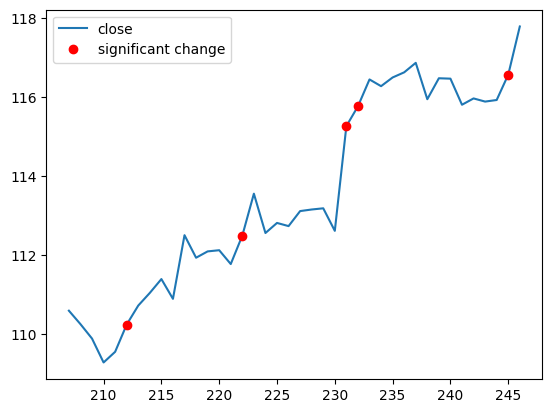

In [4]:
import random
SMOTHING_WINDOW = 40
SIGNIFICANT_CHANGE = 0.8 # z-score

s = random.randint(0, len(bars)-SMOTHING_WINDOW)
window = bars[s:s+SMOTHING_WINDOW]

close_diff = window['close'].diff().fillna(0)
close_diff = close_diff.multiply(close_diff.shift(-1)).fillna(0)
close_diff = (close_diff - close_diff.mean()) / close_diff.std()

plt.plot(window['close'], label='close')
plt.plot(window['close'][close_diff > SIGNIFICANT_CHANGE], 'ro', label='significant change')
plt.legend()

/tmp/ipykernel_69747/3561956656.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False False True True True False True True True True True
 True True False True False False False True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  close_extremum_idx.update(close_extremum > SIGNIFICANT_CHANGE)
/tmp/ipykernel_69747/3561956656.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False True True True False False False True False False False False False
 False False False False True True True False]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  close_extremum_idx.update(close_extremum < -SIGNIFICANT_CHANGE)


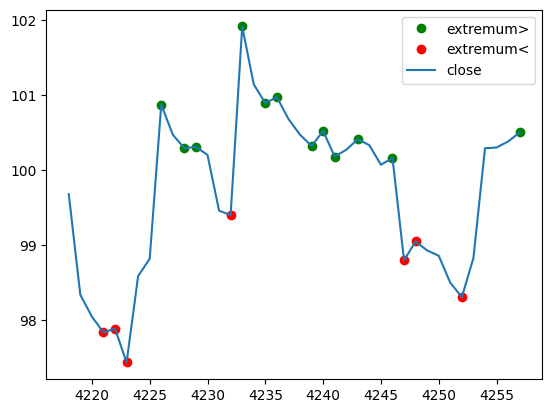

In [5]:
import random
SMOTHING_WINDOW = 40
SIGNIFICANT_CHANGE = 0.243 # z-score

s = random.randint(0, len(bars)-SMOTHING_WINDOW)
window = bars[s:s+SMOTHING_WINDOW]

close = window['close']
close_extremum_idx = (close > close.shift(1)) & (close > close.shift(-1)) | (close < close.shift(1)) & (close < close.shift(-1))
close_extremum_idx[close_extremum_idx.index[-1]] = close_extremum_idx[close_extremum_idx.index[0]] = True
close_extremum = close[close_extremum_idx]

# returns significance of p2 in the context of p1 and p3
def significance(p1: np.ndarray, p2: np.ndarray, p3: np.ndarray):
    ort_p2 = p2 - np.dot(p3-p1, p2) / (np.dot(p2, p2)) * p2
    return np.dot(ort_p2, ort_p2)

def drop_non_significant(arr: np.ndarray, significance_threshold: float):
    if len(arr) < 3:
        return arr
    if significance(arr[0], arr[1], arr[2]) < significance_threshold:
        arr = np.delete(arr, 1)
        drop_non_significant(arr, significance_threshold)
    else:
        drop_non_significant(arr[1:], significance_threshold)
    return arr

close_extremum = (close_extremum - close_extremum.mean()) / close_extremum.std()
close_extremum = drop_non_significant(np.column_stack([close_extremum.index, close_extremum.to_numpy()]), 0.1)
close_extremum = pd.Series(close_extremum[:,1], index=close_extremum[:,0])
close_extremum = (close_extremum - close_extremum.mean()) / close_extremum.std()

close_extremum_idx = pd.Series(False, index=close.index)
close_extremum_idx.update(close_extremum > SIGNIFICANT_CHANGE)
plt.plot(close[close_extremum_idx], 'go', label='extremum>', linestyle='None')

close_extremum_idx = pd.Series(False, index=close.index)
close_extremum_idx.update(close_extremum < -SIGNIFICANT_CHANGE)
plt.plot(close[close_extremum_idx], 'ro', label='extremum<', linestyle='None')

plt.plot(close, label='close')
plt.legend()

In [6]:
DOTS_TO_SELECT = 5